In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
# Desired format
# balloon 1: [[x0,y0,z0],[],[]...[xn,yn,zn]]
# balloon 2: [[x0,y0,z0],[],[]...[xn,yn,zn]]

In [3]:
def latlng_to_xy(lat, lng, origin_lat, origin_lng):
    """
    Convert latitude and longitude to relative X, Y coordinates in meters.
    Uses a simple equirectangular projection approximation.
    """
    R = 6371000  # Earth radius in meters
    x = R * np.radians(lng - origin_lng) * np.cos(np.radians(origin_lat))
    y = R * np.radians(lat - origin_lat)
    return x, y

def linear_interpolate(x, y, target_x):
    """
    Perform linear interpolation or edge value extrapolation.
    x: Array of existing timestamps
    y: Array of values corresponding to x (same length)
    target_x: Target timestamp to interpolate/extrapolate
    """
    if target_x <= x[0]:
        return y[0]  # Use the first value for timestamps before the range
    elif target_x >= x[-1]:
        return y[-1]  # Use the last value for timestamps after the range
    else:
        idx = np.searchsorted(x, target_x)  # Find the index of the closest larger value
        x0, x1 = x[idx - 1], x[idx]
        y0, y1 = y[idx - 1], y[idx]
        return y0 + (y1 - y0) * (target_x - x0) / (x1 - x0)  # Linear interpolation formula

def process_balloon_data(folder_path):
    data = {}
    all_timestamps = []
    origin_lat, origin_lng = None, None
    
    # Step 1: Parse all files and collect timestamps
    files_data = {}
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.endswith('.csv'):
            team_name = file_name.split()[0]  # Extract team name
            file_path = os.path.join(folder_path, file_name)
            
            # Load data
            df = pd.read_csv(file_path)
            df['timestamp'] = pd.to_datetime(df['time']).astype(int) // 10**9  # Convert to UNIX time
            
            # Initialize origin_lat, origin_lng from the first file's first row
            if origin_lat is None or origin_lng is None:
                origin_lat, origin_lng = df['lat'][0], df['lng'][0]
            
            # Convert lat/lng to relative x, y
            df['x'], df['y'] = zip(*df.apply(lambda row: latlng_to_xy(row['lat'], row['lng'], origin_lat, origin_lng), axis=1))
            
            files_data[team_name] = df
            all_timestamps.extend(df['timestamp'].tolist())
    
    # Step 2: Determine the unified timestamp range
    earliest_timestamp = min(all_timestamps)
    latest_timestamp = max(all_timestamps)
    
    # Extend the range to cover an integer number of minutes
    earliest_timestamp = earliest_timestamp - (earliest_timestamp % 60)
    latest_timestamp = latest_timestamp + (60 - latest_timestamp % 60)
    unified_timestamps = np.arange(earliest_timestamp, latest_timestamp + 1, 60)  # 1-minute steps
    
    # Step 3: Interpolate data for each team
    for team_name, df in files_data.items():
        timestamps = df['timestamp'].values
        x_values = df['x'].values
        y_values = df['y'].values
        z_values = df['altitude'].values
        
        # Interpolate x, y, z for unified timestamps
        interpolated_x = [linear_interpolate(timestamps, x_values, t) for t in unified_timestamps]
        interpolated_y = [linear_interpolate(timestamps, y_values, t) for t in unified_timestamps]
        interpolated_z = [linear_interpolate(timestamps, z_values, t) for t in unified_timestamps]
        
        # Combine into 1D array of [x, y, z]
        data[team_name] = np.column_stack((interpolated_x, interpolated_y, interpolated_z))
    
    return data, unified_timestamps

In [4]:
# Path to APRS folder
folder_path = "F23 495 APRS data"
balloon_data, unified_timestamps = process_balloon_data(folder_path)

# Output example
for team, coordinates in balloon_data.items():
    print(f"Team {team}: {coordinates[:5]}")

Team Mike: [[    0.             0.           279.        ]
 [    3.49397095   -52.13401479   406.01639344]
 [  -22.19907012  -266.04282933   776.77419355]
 [  113.70187761  -704.13731581  1174.91803279]
 [  263.83512152 -1223.2171078   1568.75409836]]
Team November: [[ -17.21452609   -2.22389853  280.        ]
 [ -17.21452609   -2.22389853  280.        ]
 [   2.35171121  -54.28499861  374.55737705]
 [ -40.24785764 -233.38174522  752.67213115]
 [  81.28641043 -648.51750766 1154.4516129 ]]
Team Papa: [[  11.47635072  -12.23144193  317.        ]
 [  11.47635072  -12.23144193  317.        ]
 [  11.47635072  -12.23144193  317.        ]
 [   8.10484216  -61.19307899  406.75806452]
 [  23.57086554 -298.02063208  775.59016393]]
Team Quebec: [[  -9.01713271    1.11194927  278.        ]
 [  -9.01713271    1.11194927  278.        ]
 [  -9.01713271    1.11194927  278.        ]
 [  13.96244544  -32.13715667  343.40983607]
 [  -6.93418849 -187.82828265  620.7704918 ]]


In [5]:
# Example array
#balloon_data['Mike']

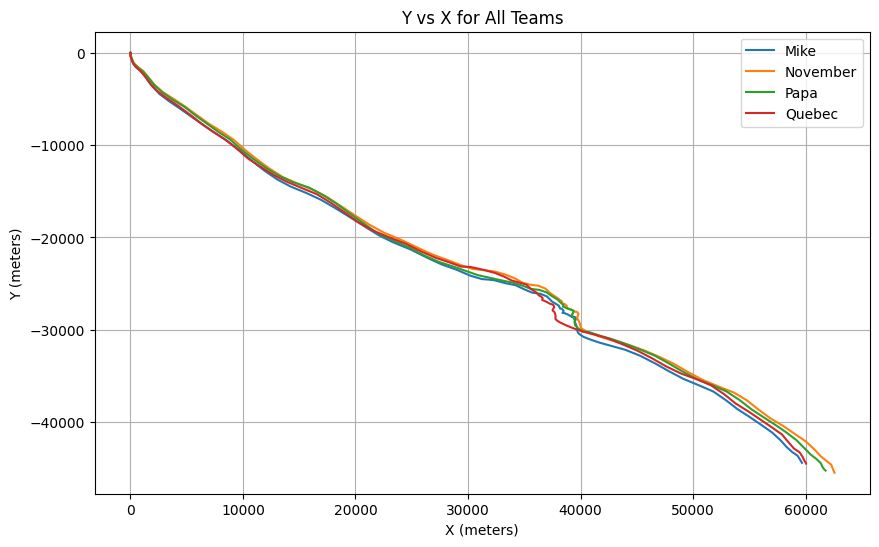

In [6]:
# Convert unified_timestamps to datetime for better x-axis labels in the z vs time plot
time_labels = [datetime.utcfromtimestamp(ts) for ts in unified_timestamps]

# Plot y vs x for all teams
plt.figure(figsize=(10, 6))
for team, coordinates in balloon_data.items():
    x, y, _ = coordinates.T  # Extract x, y, z
    plt.plot(x, y, label=team)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('Y vs X for All Teams')
plt.legend()
plt.grid()
plt.show()

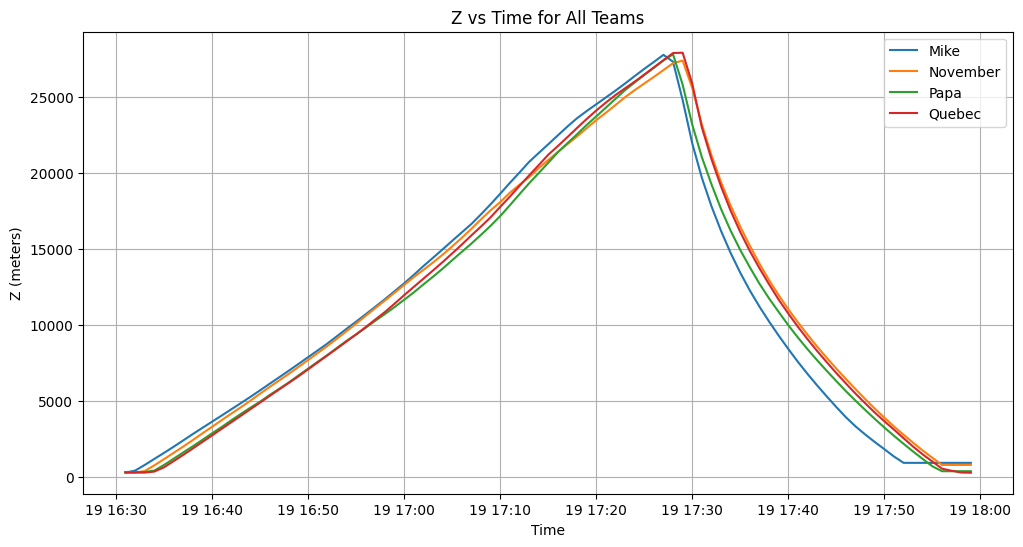

In [7]:
# Plot z vs time for all teams
plt.figure(figsize=(12, 6))
for team, coordinates in balloon_data.items():
    _, _, z = coordinates.T  # Extract x, y, z
    plt.plot(time_labels, z, label=team)
plt.xlabel('Time')
plt.ylabel('Z (meters)')
plt.title('Z vs Time for All Teams')
plt.legend()
plt.grid()
plt.show()